# Hourly Network Usage Statistics by MAC
Get detatiled and fairly accurate usage statistics for every device on your network using the version of bwmon here: https://github.com/vortex-5/ddwrt-bwmon. This is a nice little collection of scripts that interrogates the network and saves necessary information in a simple way. I wanted to be able to see changes over time, so developed this quick and dirty python program and underlying manual process to keep things running. There is still a lot that I can do to automate this, most notably using another machine as the controller - probably a RPi as it used to be before being repurposed for ADSB. 

The README.md file has more information on the hardware, but I am using a Buffalo router running DD-WRT that does not have permamanent memory. So if the router goes down there is a process to reload and restart the process. ORiginally, this was an automatic process fired off by an RPi watching on SCP, but currently it is manual. 

If the router goes down, you have to do this to restore BWMON:
```
scp -i ~/.ssh/router -r ~/Documents/repositories/Router-Tools/bwmon root@192.168.XXX.XXX:/var
scp -i ~/.ssh/router mac-names.txt root@192.168.XXX.XXX:/tmp/var/bwmon/www/mac-names.js
```

Here are some handy SCPs for the manual part of the process.

Backup the bwmon directory:
```
scp -i ~/.ssh/router -r root@192.168.XXX.XXX:/var/bwmon /Users/samuelcroker/Documents/repositories/Router-Tools/
```
Note, the bwmon directory
```
ssh -i ~/.ssh/router root@192.168.XXX.XXX
/var/bwmon/start.sh
```
The cron jobs are saved in the dd-wrt app, which appears not to be volitile. We should check that out sometime.

Grab the daily updates:
```
scp -i ~/.ssh/router root@192.168.XXX.XXX:/var/bwmon/data/*.dat ~/Documents/routerdata
```


In [1]:
import pandas as pd
import numpy as np
import datetime
import os
from os import walk
import calmap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()

# Usage Note:
The history is maintained for all time in the second folder listed above. The router will keep all copies up until it loses power, then they are lost. For that reason, it is essential to maintain another copy. In the past, I have used a slave RPi to perform this function, but it was needed for another project so that fell by the wayside. In the current configuration I am using another computer but this is a manual process. Obviously there are lots of optimizations that can happen to fully develop this concept, but it is good enough for what it was designed to do.



In [ ]:
#Get user input - router ip address
router_ip = input("Router Admin IP:")

In [3]:
%%time
#update the mac list - this will only run under Macbook
#os.system("scp -i ~/.ssh/router mac-names.txt root@192.168.11.1:/tmp/var/bwmon/www/mac-names.js")
# move the dailyfiles - look for a 0 return code

retcd = os.system("scp -i ~/.ssh/router root@" + router_ip +":/var/bwmon/data/*.dat ~/Documents/routerdata")
if retcd ==0:
    print("Successfully retrieved data from router")
else:
    print("An error occured in data transfer from router. ERR=",str(retcd))

Successfully retrieved data from router
CPU times: user 1.74 ms, sys: 3.86 ms, total: 5.6 ms
Wall time: 12.7 s


In [4]:
%%time
maccsv = '/Users/samuelcroker/Documents/repositories/Router-tools/mac-names.csv'
macdf = pd.read_csv(maccsv, names = ['mac','devicename'],quotechar="'")
hourlypath = '/Users/samuelcroker/Documents/routerdata/'
hourlyfiles = []
for (dirpath, dirnames, filenames) in walk(hourlypath):
    hourlyfiles.extend(filenames)
    break
macdf['MAC'] = macdf[str.lower('mac')]

CPU times: user 10.6 ms, sys: 11.4 ms, total: 21.9 ms
Wall time: 52.8 ms


In [5]:
%%time
cutoff = 1.5
idx = 0
dailypath = '/Users/samuelcroker/Documents/routerdata/'
dailyfiles = []
for (dirpath, dirnames, filenames) in walk(dailypath):
    dailyfiles.extend(filenames)
    break
for f in hourlyfiles:
    date_parser = pd.to_datetime
    dtypes = {'MAC':'str','PostIN KB':'int','PostOut KB':'int','PreIn KB':'int','PreOut KB':'int','LastSeen':'str'}
    headers =  ['MAC','PostIN KB','PostOut KB','PreIn KB','PreOut KB','LastSeen']
    parse_dates =  ['LastSeen']
    if f[-3:] == 'dat' and f[0:6] == 'hourly':
#         print(f)
        df = pd.read_csv(hourlypath+f, names=headers, dtype=dtypes, parse_dates=parse_dates )
        df['idx'] = idx
        if idx == 0:
            finaldf = df.copy()                 
        else:
            finaldf = pd.concat([finaldf,df])
        idx += 1

CPU times: user 6.91 s, sys: 222 ms, total: 7.13 s
Wall time: 10.8 s


## After successful download, consider cleaning out the remote directory

```
ssh -i ~/.ssh/router root@192.168.XXX.XXX

nvram show | grep size

cd /var/bwmon/data
rm <<files>>
```

## Augmentation of data, final prep

In [6]:
%%time
#calculate the totalGB column. This is approximate but very close...
finaldf['totalGB'] = (finaldf['PostIN KB'] + finaldf['PostOut KB'])/1e6
finaldf['dtstamp'] = finaldf['LastSeen'].dt.date
finaldf['hour'] = finaldf['LastSeen'].dt.hour
finaldf['year'] = finaldf['LastSeen'].dt.year
finaldf['day'] = finaldf['LastSeen'].dt.day
finaldf['month'] = finaldf['LastSeen'].dt.month

days ={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:"Sun"}
finaldf['dow'] = finaldf['LastSeen'].dt.weekday.map(days)


pb = finaldf.MAC.nunique()
#join with devicenames
finaldf = finaldf.merge(macdf, left_on='MAC', right_on='MAC', how='left')
#Make sure unknown devices are not ignored in the groupby by replacing the null devicename with
# the mac address
finaldf.devicename.fillna(finaldf['MAC'], inplace=True)
pa = finaldf.MAC.nunique()
print("Quality Check: " + str(pb) + " " + str(pa))

Quality Check: 34 34
CPU times: user 67.7 ms, sys: 4.12 ms, total: 71.8 ms
Wall time: 77.8 ms


In [7]:
finaldf = finaldf[['MAC','LastSeen','dtstamp','year','month','day','hour','dow','totalGB','devicename']]
finaldf.head()

,MAC,LastSeen,dtstamp,year,month,day,hour,dow,totalGB,devicename
0,00:1f:e1:3e:09:8b,2018-05-04 10:30:00,2018-05-04,2018,5,4,10,Fri,0.000005,'Vonage'
1,70:56:81:dd:c2:0a,2018-05-04 10:37:00,2018-05-04,2018,5,4,10,Fri,0.000006,'Apple TV ETH'
2,5c:f5:da:b0:54:ed,2018-05-04 10:38:00,2018-05-04,2018,5,4,10,Fri,0.065072,'Joyes iPad'
3,f0:a2:25:c5:9d:b2,2018-05-04 10:46:00,2018-05-04,2018,5,4,10,Fri,0.000256,'Gen 1 Kindle'
4,10:ae:60:35:74:d4,2018-05-04 10:47:00,2018-05-04,2018,5,4,10,Fri,0.000097,'Amelias Kindle'


In [8]:
#dropouts - get list of MACs that havent been on the network for awhile:
#finaldf['legacy'] =
print('This is a list of devices not seen in the past 10 days:')
drops = finaldf.groupby(['MAC','devicename'])['LastSeen'].max()< datetime.datetime.now() - datetime.timedelta(days=10)
drops[drops == True]

This is a list of devices not seen in the past 10 days:


MAC                devicename           
00:0d:4b:bf:73:e1   'Roku-Orig WLAN'        True
00:56:cd:07:db:05   'Trish A.'              True
9c:f4:8e:92:9f:34   'Devrin K.'             True
b8:27:eb:cf:4e:b8   'Piaware ETH'           True
c0:d3:c0:87:37:d9   'Phil R.'               True
c8:d5:fe:00:fe:fe   'Dopo Tablet'           True
cc:20:e8:06:5d:fa   'SAS iPhone'            True
e0:cb:1d:55:a7:79   'Samuels Kindle'        True
f0:a2:25:f0:e4:60   '<<Private f0::60>>'    True
Name: LastSeen, dtype: bool

In [9]:
#calculate some values for determining temporal location
dyear = datetime.datetime.now().year 
dmonth =datetime.datetime.now().month - 2
if dmonth <= 0:
    dyear += -1
    dmonth = 12 + dmonth

In [10]:
%%time
# create summaries
Alltotal = finaldf.groupby(['MAC','devicename'])['totalGB'].sum()
all_final = finaldf
devicetotal = finaldf.groupby(['devicename'])['totalGB'].sum()
dailytotal = finaldf.groupby(['dtstamp'])['totalGB'].sum()
smalldaily = finaldf[finaldf.totalGB < cutoff].groupby(['dtstamp','devicename'])['totalGB'].sum()

if datetime.datetime.now().month == 1:
    lastK = datetime.date(datetime.datetime.now().year-1, 12 , 28)
elif datetime.datetime.now().day > 28:
    lastK = datetime.date(datetime.datetime.now().year,datetime.datetime.now().month, 28)
else:
    lastK = datetime.date(datetime.datetime.now().year,datetime.datetime.now().month -1 , 28)
print(lastK)
recentdf = finaldf[finaldf['dtstamp'] > lastK]
#this is empty until we get past Apr 28, 2018
nonrecentdf = finaldf[finaldf['dtstamp'] <= lastK]
print(len(recentdf))
print(len(nonrecentdf))

2018-04-28
4086
2558
CPU times: user 27.9 ms, sys: 4.34 ms, total: 32.2 ms
Wall time: 34 ms


# Visualize the results
## Billing cycle ends on the 28th

In [11]:
#calculate usage since last month end:

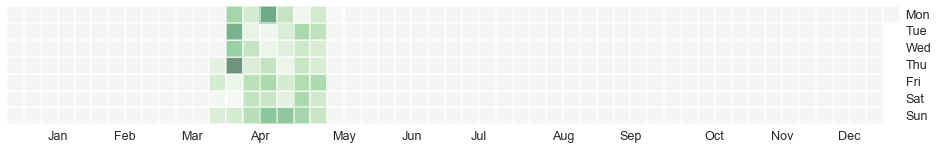

In [12]:
alldaily = pd.read_pickle('/Users/samuelcroker/Documents/routerdata/legacy.p').append(dailytotal)
alldaily.index = pd.to_datetime(alldaily.index)
plt.rcParams['figure.figsize'] = 16, 8
calmap.yearplot(data=alldaily,year=2018,cmap='Greens',alpha=.55)

In [13]:
#integrate legacy data from previous version of this analysis.
# note this data does not contain hourly results.

legacydf = pd.read_pickle('/Users/samuelcroker/Documents/routerdata/legacyDaily.p')
final_legacy = legacydf.append(nonrecentdf)

# data quality check
flu = pd.DataFrame(final_legacy.devicename.unique())
fru = pd.DataFrame(recentdf.devicename.unique())
flu.columns = ['LegacyDevice']
fru.columns = ['RecentDevice']

#uncomment below to check
#flu.merge(fru,left_on='LegacyDevice',right_on='RecentDevice',how='outer')

In [14]:
#stil need to add recent legacy (dont have until apr 28)
# Eventually, we can replace this legacy code with the monthly average 
# over devices rather and it will give a better picture of the month to month.
# we should also add a power-company-like graph that shows the month
# over month change by heavy utilizing devices, or devices that have
# a big month to month util change - the AVG scenario

all_device = finaldf.groupby(['devicename'])['totalGB'].sum()
recent_device = recentdf.groupby(['devicename'])['totalGB'].sum()
nonrecent_device = nonrecentdf.groupby(['devicename'])['totalGB'].sum()

all_device.sort_values(ascending=False,inplace=True)
recent_device.sort_values(ascending=False,inplace=True)
nonrecent_device.sort_values(ascending=False,inplace=True)

# legacy_device = legacydf.groupby(['devicename'])['totalGB'].sum()
# legacy_device.sort_values(ascending=False,inplace=True)

# za =  pd.DataFrame(recent_device)
# # zb =  pd.DataFrame(legacy_device)
# zc = pd.DataFrame(nonrecent_device)
# za['device'] = za.index
# # zb['device'] = zb.index
# zc['device'] = zc.index

# zap = za.merge(zc, how='outer',left_on='device',right_on='device')
# # zbp = zb.merge(za, how='outer',left_on='device',right_on='device')

# zap.totalGB_x.fillna(zap.totalGB_y,inplace=True)
# zaps = pd.Series(zap['totalGB_y'].values,index=zap['device'])
# zaps.sort_values(ascending=False,inplace=True)

col_ord = all_device.index.tolist()
# zaps = zaps.reindex(index=col_ord)

# zbps = pd.Series(zbp['totalGB_x'].values,index=zbp['device'])

# legacy_device = zbps.reindex(index=col_ord)
recent_device = recent_device.reindex(index=col_ord)
nonrecent_device= nonrecent_device.reindex(index=col_ord)

## List devices and usage
This graph shows previous usage as orange bacground and current as blue foreground. I think there is a problem that will have to be looked at as the previous legacy data should be a monthly max rather than a sum. Maybe it is alredy doing that - but take a look anyway.

what this shows is what devices are seeing a increase or decrease in usage, and since the graph is in logarithmic scale on the y axis, both high and low utilizers are seen.

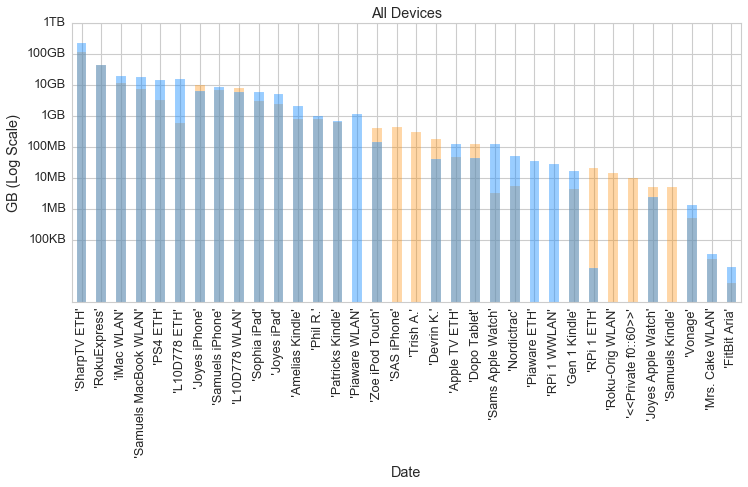

In [15]:
#tt is the tick marks and tlab is the associated labels. I put them like this for readability
tt = [0.0001,0.001,0.01,0.1,1,10,100,1000]
tlab = ['100KB','1MB','10MB','100MB','1GB','10GB','100GB','1TB']

pp0 = nonrecent_device.plot(kind='bar',color='darkorange',alpha=.35,stacked=False, figsize=(12, 5),logy=True,yticks=tt)
pp0 = recent_device.plot(kind='bar',color='dodgerblue',alpha=0.45,stacked=False, figsize=(12, 5),logy=True,yticks=tt)
pp0.set_yscale = 'symlog'
pp0.set_yticklabels(tlab)
pp0.set_xlabel('Date')
pp0.set_ylabel('GB (Log Scale)')
pp0.set_title("All Devices")

# Legacy Daily Utilization

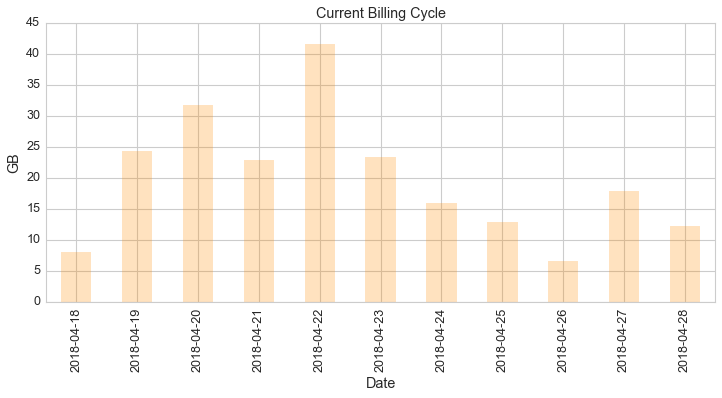

In [16]:
nonrecentdaily = nonrecentdf.groupby(['dtstamp'])['totalGB'].sum()
pp0 = nonrecentdaily.plot(kind='bar',stacked=False, color='darkorange',alpha=0.25,figsize=(12, 5))
pp0.set_xlabel('Date')
pp0.set_ylabel('GB')
pp0.set_title("Current Billing Cycle")

# Current Daily Utilization

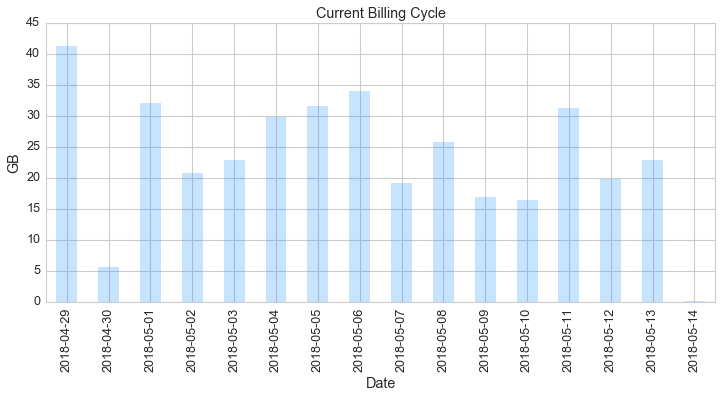

In [17]:
recentdaily = recentdf.groupby(['dtstamp'])['totalGB'].sum()
pp0 = recentdaily.plot(kind='bar',stacked=False, color='dodgerblue',alpha=0.25,figsize=(12, 5))
pp0.set_xlabel('Date')
pp0.set_ylabel('GB')
pp0.set_title("Current Billing Cycle")

# Progression Towards 1TB Data Cap

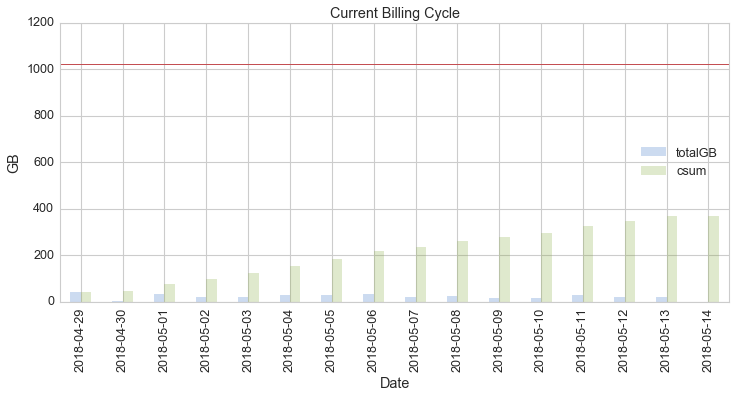

In [18]:
recentDF = pd.DataFrame(recentdf.groupby(['dtstamp'])['totalGB'].sum())
recentDF['csum'] = recentDF['totalGB'].cumsum()

tt = [0.0001,0.001,0.01,0.1,1,10,100,1000,2048]
tlab = ['100KB','1MB','10MB','100MB','1GB','10GB','100GB','1TB']

# pp0 = recentDF.plot(kind='bar',stacked=False, alpha=0.25,figsize=(12, 5),logy=True,yticks=tt)
# pp0.set_yscale = 'symlog'
# pp0.set_yticklabels(tlab)
pp0 = recentDF.plot(kind='bar',stacked=False, alpha=0.25,figsize=(12, 5))
pp0.set_xlabel('Date')
pp0.axhline(y=1024,linewidth=1, color='r')
pp0.set_ylabel('GB')
pp0.set_title("Current Billing Cycle")

# Hourly Utilization
### Shows legacy vs current billing cycle 
Orange background = Legacy
Blue foreground = Current billing cycle

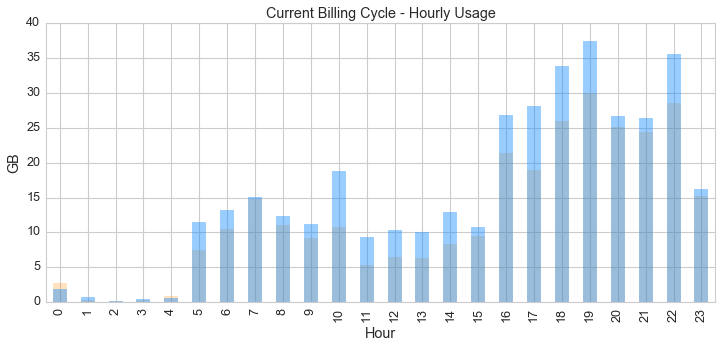

In [19]:
hourlyall = finaldf.groupby(['hour','month'])['totalGB'].sum().groupby(level=[0]).mean().sort_index()
hourlycurrent = recentdf.groupby(['hour'])['totalGB'].sum().sort_index()

pp0 = hourlyall.plot(kind='bar',stacked=False, color='darkorange',alpha=0.25,figsize=(12, 5))
pp0 = hourlycurrent.plot(kind='bar',stacked=False, color='dodgerblue',alpha=0.45,figsize=(12, 5))
#overlay current billing cycle
pp0.set_xlabel('Hour')
pp0.set_ylabel('GB')
pp0.set_title("Current Billing Cycle - Hourly Usage")

# Device Hourly Heatmap
This graph is useful for finding devices that are being utilized at odd times. For example, I would not want to see one of the kids iPads with high utilization during the middle of the night potentially indicating unsupervised YouTube usage.

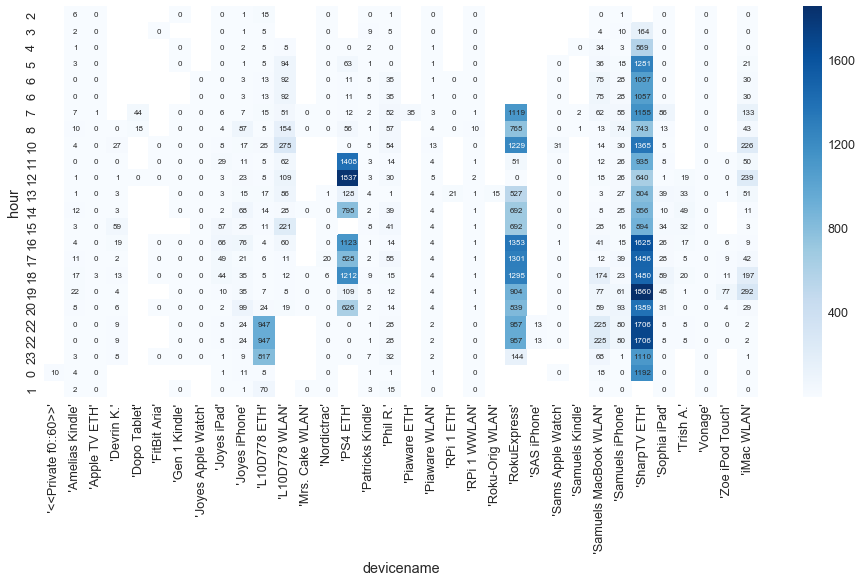

In [20]:
import math

hourorder =[2,3,4,5,6,6,7,8,10,11,12,13,14,15,16,17,18,19,20,22,22,23,0,1]

finaldf['totalMB'] = finaldf['totalGB']*1000
finaldf['totalMBlog'] = finaldf['totalMB'].apply(lambda x: math.log(x))
devicehour = pd.pivot_table(data=finaldf,index='hour',values='totalMB',columns='devicename',aggfunc='mean')#,fill_value=0)

plt.subplots(figsize=(16, 7))
devicehour=devicehour.reindex(index=hourorder)
sns.heatmap(devicehour, cmap='Blues',annot=True,fmt=".0f",annot_kws={'size':8})

In [21]:
# Print a table of this graph - uncomment for use
# devicehour.sum().sort_values(ascending=False)

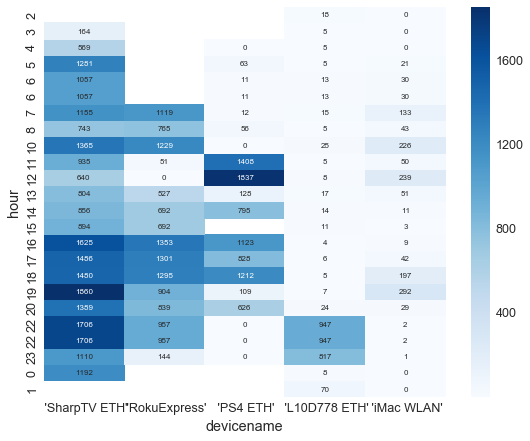

In [22]:
largemac = devicehour[devicehour.columns.intersection(devicehour.sum().nlargest(5).index.tolist())]
largemac = largemac.reindex(index=hourorder)
plt.subplots(figsize=(9, 7))
sns.heatmap(largemac, cmap='Blues',annot=True,fmt=".0f",annot_kws={'size':8})

# Day of Week by Hour

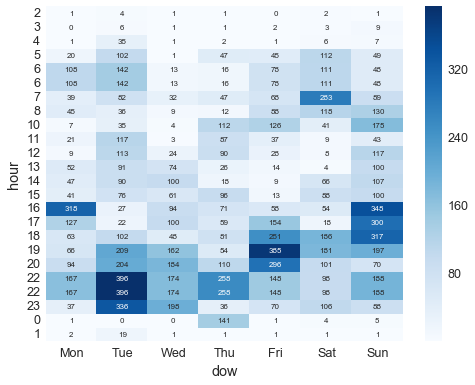

In [23]:
weekdays = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
dayhour = pd.pivot_table(data=finaldf,index='dow',values='totalMB',columns='hour',aggfunc='mean')#,fill_value=0)
dayhour = dayhour.reindex(weekdays).transpose()
dayhour = dayhour.reindex(index=hourorder)
plt.subplots(figsize=(8,6))
sns.heatmap(dayhour, cmap='Blues',annot=True,fmt=".0f",annot_kws={'size':8})

## Scratchpad

In [24]:
# # Lost macs
# # 5c:8d:4e:d9:7c:f8
# # f0:a2:25:f0:e4:60 (only 1 occurrance - Sunday 4-22)
# # e4:e4:ab:bf:39:df Pretty frequent
# finaldf[finaldf['MAC']=='e4:e4:ab:bf:39:df'].sort_values(by='LastSeen')